<a href="https://colab.research.google.com/github/flybiubiu/cs231n/blob/master/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [0]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [0]:
!pip install imageio

In [0]:
%cd cs231n/datasets/
!./get_datasets.sh

/content/google-colab-cs231n/assignment1/cs231n/datasets
--2019-09-27 13:44:53--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.2MB/s    in 13s     

2019-09-27 13:45:07 (12.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)#10.0*8.0像素的图
plt.rcParams['image.interpolation'] = 'nearest'#显示图像中间空白最小 #使用%laod_ext自动重装载入
%load_ext autoreload  
%autoreload 2  #无参数装入所有模块,0参数不执行装入模块,1参数加载自动加载的模块,2参数加载不用自动加载的模块

In [0]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ',y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


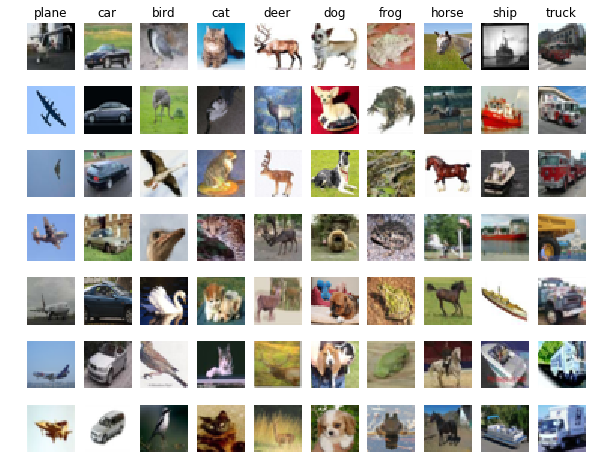

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7#显示几张同一类型的图片
for y, cls in enumerate(classes):#y代表标签,cls代表分类(classes)
  idxs = np.flatnonzero(y_train == y)#返回矩阵中非零元素的位置,y_train==y即为非零,类似于boolean类型
  idxs = np.random.choice(idxs, samples_per_class, replace=False)#随机选择idxs(也就是分类正确)的图片,samples+per_class=7表示显示7张,replace参数表示不允许重复
  for i, idx in enumerate(idxs):#enumerate枚举函数,类似于c语言中{}用法,对于一个可以迭代的对象，可以同时获得索引个值,i为索引,idx为索引值，在这里，索引值为分类正确的位置
    plt_idx = i * num_classes + y + 1#确认每幅图的区域坐标,subplot函数的左上角编号为1,i从0开始,i*num_classes代表了竖向输出,由于i和y从0开始,而subplot编号从1开始,所以得+1
    plt.subplot(samples_per_class, num_classes, plt_idx)#绘制多个子图,samples_per_class代表行数,num_classes代表了列数,plt_idx参数指定图像的区域
    plt.imshow(X_train[idx].astype('uint8'))#对于每个索引值idx,用uint8类型输出，就是一幅图
    plt.axis('off')#关闭横纵坐标显示
    if i == 0:
      plt.title(cls)

In [0]:
num_training = 5000#5000个训练图像，为什么不用49000个，因为时间太长，所以我们认为的缩小训练数据量
mask = range(num_training)#mask存一维0:5000
X_train = X_train[mask]#X_train为一训练集0:5000
y_train = y_train[mask]#y_train为X_train对应的标签

num_test = 500#500个测试数据
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))#第一个参数为转换对象,reshape为转换矩阵形状,行列变换,X_train为5000,X_train.shape[0]为第二维的长度,行数,shape[1]为第一维长度,列数,-1一行数量未知，直接到最后,这里实际值为32*32*3
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
class KNearestNeighbor(object):#原cs231n课题中要求直接使用KNearestNeighbor()函数,他们已经实现好了,这里我们手动实现
  def __init__(self):
    pass
  def train(self, X, y):
    self.X_train = X
    self.y_train = y
  def predict(self, X, k = 1, num_loops = 0):#预测函数,num_loops为范数类型,也就是计算距离的算法
    if num_loops == 0:#计算矩阵间的欧氏距离,不用循环,用矩阵速度特别快
      dists = self.compute_distances_no_loops(X)#返回一个向量
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)#计算欧式距离，指定了axis=1行方向,通过python的[i, :]计算
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)#计算欧式距离，朴素公式，通过两层for循环
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)
    return self.predict_labels(dists, k = k)
  def compute_distances_two_loops(self, X):
    num_test = X.shape[0]#测试集第二维数
    num_train = self.X_train.shape[0]#训练集第二维数
    dists = np.zeros((num_test, num_train))#行数为num_test,列数为num_train的0矩阵
    for i in range(num_test):#两层for循环
      for j in range(num_train):
        dists[i, j] = np.linalg.norm(X[i] - self.X_train[j])
    return dists
  def compute_distances_one_loop(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      dists[i] = np.linalg.norm(X[i] - self.X_train, axis = 1)
    return dists
  def compute_distances_no_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    x2 = np.sum(X ** 2,axis = 1).reshape((num_test, 1))
    y2 = np.sum(self.X_train ** 2, axis = 1).reshape((1, num_train))
    xy = -2 * np.matmul(X, self.X_train.T)#求两矩阵相乘
    dists = np.sqrt(x2 + xy + y2)
    return dists
  def predict_labels(self, dists, k = 1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype = int)#生成num_test大小的向量
    for i in range(num_test):
      closest_x = np.argsort(dists[i])[:k]#排序,对每一个类别形成一个距离数值，组成一个向量,k=1,取最近的一个的标签,这里是arg,不是sort,argsort是返回列表类型的下标
      closest_y = [self.y_train[val] for val in closest_x]#通过下标返回类别标签
      labels, count = np.unique(closest_y, return_counts = True)#去重，并且返回每一数值的个数,以此求出最有可能的分类,
      y_pred[i] = labels[np.argmax(count)]#counts为一维列表,求出count投票最多的那个标签下标,并且转换成标签
    return y_pred

In [0]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [0]:
dists = classifier.compute_distances_two_loops(X_test)
print (dists.shape)#500*(32*32*3)   *  (32*32*3)*5000

(500, 5000)


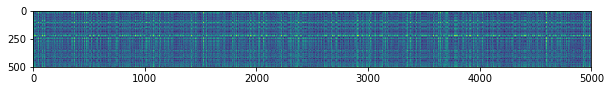

In [0]:
plt.imshow(dists, interpolation='none')#无间距显示图像
plt.show()

In [0]:
y_test_pred = classifier.predict_labels(dists, k = 1)#k=1,最邻近算法,已退化
num_correct = np.sum(y_test_pred == y_test)#统计分类结果符合实际的个数
accuracy = float(num_correct) / num_test#求出正确率
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [0]:
y_test_pred = classifier.predict_labels(dists, k = 5)#k=5,需要五个匹配度最高的投票，统计分类标签次数最多的
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d /%d correct => accuracy: %f' % (num_correct, num_correct, accuracy))

Got 139 /139 correct => accuracy: 0.278000


In [0]:
dists_one = classifier.compute_distances_one_loop(X_test)#测试一次循环的效果
difference = np.linalg.norm(dists - dists_one, ord='fro')#ord参数为范数类型,fro为二范数 弗罗贝尼乌斯(Frobenius),也就是欧氏距离

In [0]:
print ('Difference was: %f' % (difference, ))#,用法为固定好行数，输出所有的列数
if difference < 0.001:
  print ('Good!')
else:
  print ('Oops!')

Difference was: 0.000000
Good!


In [0]:
dists_two = classifier.compute_distances_no_loops(X_test)#测试不循环,使用矩阵相乘的算法
difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' %  (difference, ))
if difference < 0.001:
  print ('Good!')
else:
  print ('Oops!')

Difference was: 0.000000
Good!


In [0]:
def time_function(f, *args):
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)
one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)
no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

Two loop version took 30.339020 seconds
One loop version took 45.508398 seconds
No loop version took 0.631224 seconds


In [0]:
num_folds = 5#交叉检验分块的数量
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]#分别为k的数值
X_train_folds = []#存放对应k不同的时对于数据的分块
y_train_folds = []#存放对应k不同的时对于标签的分块
pass#空语句,一般不作任何事情,占位,为了保持程序的完整性
avg_size = int(X_train.shape[0] / num_folds)#交叉检验每一块的数量
for i in range(num_folds):
  X_train_folds.append(X_train[i * avg_size : (i + 1) * avg_size])#数据追加整合,X_train_fold下标变为0,1,2,3,4
  y_train_folds.append(y_train[i * avg_size : (i + 1) * avg_size])#标签追加整合,y_train_fold下标变为0,1,2,3,4
k_to_accuracies = {}#字典类型
pass#空语句,一般不作任何事情,占位,为了保持程序的完整性
for k in k_choices:
  accuracies = []
  print (k)
  for i in range(num_folds):
    X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])#竖直方向堆叠,0~i-1,i+1~end，刚好跳过i段
    y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])#水平方向堆叠
    X_valid_cv = X_train_folds[i]#确定验证数据集
    y_valid_cv = y_train_folds[i]#确定验证标签集
    classifier.train(X_train_cv, y_train_cv)#训练
    dists = classifier.compute_distances_no_loops(X_valid_cv)#使用矩阵求验证集距离
    accuracy = float(np.sum(classifier.predict_labels(dists, k) == y_valid_cv)) / y_valid_cv.shape[0]#对应于k值，求验证集的准确率
    accuracies.append(accuracy)#将准确率存放在accuracies里，以追加的方式
  k_to_accuracies[k] = accuracies
for k in sorted(k_to_accuracies):#k_to_accuracies字典类型
  for accuracy in k_to_accuracies[k]:
    print ('k = %d, accracy = %f' % (k, accuracy))

1
3
5
8
10
12
15
20
50
100
k = 1, accracy = 0.263000
k = 1, accracy = 0.257000
k = 1, accracy = 0.264000
k = 1, accracy = 0.278000
k = 1, accracy = 0.266000
k = 3, accracy = 0.239000
k = 3, accracy = 0.249000
k = 3, accracy = 0.240000
k = 3, accracy = 0.266000
k = 3, accracy = 0.254000
k = 5, accracy = 0.248000
k = 5, accracy = 0.266000
k = 5, accracy = 0.280000
k = 5, accracy = 0.292000
k = 5, accracy = 0.280000
k = 8, accracy = 0.262000
k = 8, accracy = 0.282000
k = 8, accracy = 0.273000
k = 8, accracy = 0.290000
k = 8, accracy = 0.273000
k = 10, accracy = 0.265000
k = 10, accracy = 0.296000
k = 10, accracy = 0.276000
k = 10, accracy = 0.284000
k = 10, accracy = 0.280000
k = 12, accracy = 0.260000
k = 12, accracy = 0.295000
k = 12, accracy = 0.279000
k = 12, accracy = 0.283000
k = 12, accracy = 0.280000
k = 15, accracy = 0.252000
k = 15, accracy = 0.289000
k = 15, accracy = 0.278000
k = 15, accracy = 0.282000
k = 15, accracy = 0.274000
k = 20, accracy = 0.270000
k = 20, accracy = 0.2

[1]
[3]
[5]
[8]
[10]
[12]
[15]
[20]
[50]
[100]


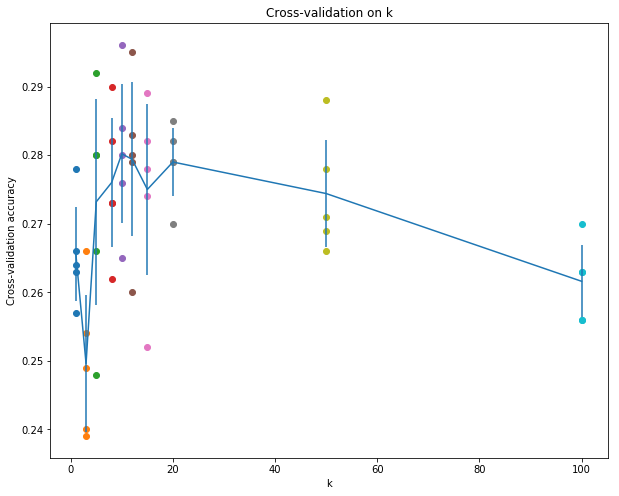

In [0]:
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)#画点,[k]形成1*1的矩阵,因为scatter函数需要两个参数类型相同,len(accuracies)为5,表示画五个点
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])#求五个点平均数
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])#求五个点标准差
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)#误差曲线,第二个参数为线段连线,第三个为上下浮动部分,为标准差
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
best_k = 10
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
